<a href="https://colab.research.google.com/github/RohanWork/RohanWork/blob/main/Rich_Gourd_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive/Mydrive/Dataset',force_remount=True)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import cv2
import os
import pandas as pd
import keras
import tensorflow
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import Sequential
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Flatten

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D 
#from keras.layers.convolutional import Conv2D
#from keras.layers.convolutional import MaxPooling2D

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import warnings
warnings.filterwarnings('ignore')
import itertools
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import sys
print('Done')

Done


In [ ]:
#--------------------
# tunable-parameters
#--------------------
images_per_class       = 100   #800
fixed_size             = tuple((256, 256))
train_path             = "/content/drive/MyDrive/CapstoneData/dataset/ridgegourd"
train_path1             = "/content/drive/MyDrive/CapstoneData/dataset/ridgegourd"
print('Done')

Done


In [ ]:
# Image Segmentation

# It separates leaf image from background image
def img_segmentation(b):
  
    pixel_vals = b.flatten()
    pixel_vals = np.float32(pixel_vals)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    # Since we are interested in only actual leaf pixels, we choose 2 clusters
    # one cluster for actual leaf pixels and other for unwanted background pixels.
    K = 2
    retval, labels, centers = cv2.kmeans(pixel_vals, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    centers = np.uint8(centers)
    segmented_data = centers[labels.flatten()]
    segmented_image = segmented_data.reshape((b.shape))
    pixel_labels = labels.reshape(img_lab.shape[0], img_lab.shape[1])
    pixel_labels = np.uint8(pixel_labels)
    ret, components = cv2.connectedComponents(pixel_labels, connectivity=8)
    indices = []
    for i in range(1, ret):
        row, col = np.where(components==i)
        indices.append(max(len(row), len(col)))
        component = np.argmax(np.array(indices))
    main_component = component+1   #indexing starts from 0, so we increment by 1 to get actual component index# creating a mask and extracting pixels corresponding to cluster to which leaf belongs.
    # 1 for actual leaf pixels and 0 for other pixels
    mask = np.where(components==main_component, 1, 0)
    B = image[:, :, 0]
    G = image[:, :, 1]
    R = image[:, :, 2]# Extract only masked pixels
    r = R*mask
    g = G*mask
    b = B*mask
    final_img = np.dstack((r, g, b))
    v_sum = np.sum(mask, axis=0)
    h_sum = np.sum(mask, axis=1)
    w = np.count_nonzero(v_sum)
    h = np.count_nonzero(h_sum)
    x_indices = np.where(v_sum != 0)
    y_indices = np.where(h_sum != 0)
    x = x_indices[0][0]
    y = y_indices[0][0]
    final_crop_img = final_img[y:y+h-1, x:x+w-1, :]
    final_crop_img = np.uint8(final_crop_img)
    img = cv2.resize(final_crop_img, (256,256), interpolation=cv2.INTER_AREA)
    return img
    

In [ ]:
# !fusermount -u drive
# !google-drive-ocamlfuse drive

In [ ]:
# get the training labels
train_labels = os.listdir(train_path)
#train_labels=[x for x in train_labels if "Ridge" in x]

# sort the training labels
train_labels.sort()
print(train_labels)
print("No of classes",len(train_path))
print('Done')

['Results', 'imgs_original.npy', 'original.csv', 'sam']
No of classes 57
Done


In [ ]:
# # Count no.of images w.r.t each disease
img_count = {}
for folder in train_labels:
    cnt = len(os.listdir(train_labels))
    img_count[folder] = cnt
# Plotting barplots of no.of leaf images w.r.t each disease
plt.bar(img_count.keys(), img_count.values())
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
# get the training labels
train_labels = os.listdir(train_path)
#train_labels=[x for x in train_labels if "Ridge Gourd" in x]

# sort the training labels
train_labels.sort()
print(train_labels)
print("No of classes",len(train_labels))

# empty lists to hold feature vectors and labels
global_features = []
labels          = []

img_names = []
img_array = []
labels = []

# loop over the training data sub-folders
for training_name in train_labels:
    # join the training data path and each species training folder
    #if "Ridge" not in training_name:
    #    continue
    dir = os.path.join(train_path, training_name)

    # get the current training label
    current_label = training_name
    
    files=os.listdir(dir)
    print(len(files))
    nc=images_per_class
    if len(files)< images_per_class:
      nc=len(files)-1
    
    print(nc)
    # loop over the images in each sub-folder
    for x in range(nc+1):
        # get the image file name
        file = dir + "/" + files[x]

        # read the image and resize it to a fixed-size
        #print(file)
        image = cv2.imread(file) # It stores image in BGR format
        
        
        image = cv2.resize(image, fixed_size)

        
        # Choose Color Channel
        img_lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        # Lab Color Space - https://en.wikipedia.org/wiki/CIELAB_color_space
        L = img_lab[:, :, 0]
        a = img_lab[:, :, 1]
        b = img_lab[:, :, 2]
        
        IMG_SEGMENT   = img_segmentation(b)
        im_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        im_size = cv2.resize(im_rgb, (144, 144), interpolation=cv2.INTER_AREA)
        
        img_names.append(im_rgb)
        img_array.append(im_size)
        labels.append(training_name)

df = pd.DataFrame({'Image ID': img_names, 'Class': labels})
df.to_csv(train_path1+'/original.csv', index=False)

X = np.asarray(img_array)
np.save(train_path1+'/imgs_original', X)        


data = pd.read_csv(train_path1+'/original.csv')
data.head()

# Mapping original class labels to integer values
# Ex: Bacterial Blight-0, Brown Spot-1, ..etc
labels = {}
val_cnt = 0
for folder in train_labels:
    labels[folder] = val_cnt
    val_cnt = val_cnt+1
X = np.load(train_path1+'/imgs_original.npy')
y = data['Class'].map(labels).values
data['Image Array'] = X.tolist()
data['Labels'] = y
data.head()

#split the data into train and test data in the ratio of 85:15
X = data.drop(['Image ID', 'Class', 'Labels'], axis=1)
y = data['Labels']
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.15, stratify=y, random_state=0)
imbalance_train = X_tr.copy()
imbalance_train['Labels'] = y_tr
imbalance_train['Labels'].value_counts()
    

#sys.exit(0)    

#perform upsampling such that all the classes have same no. of samples
majority_class = imbalance_train[imbalance_train.Labels == len(train_labels)-1]# Upsampling for imbalance dataset in python
upsampled_classes = [majority_class]
minority_labels = list(range(0,len(train_labels)-1))
for i in minority_labels:
    minority_class = imbalance_train[imbalance_train.Labels == i]
    minority_upsampled = resample(minority_class, replace = True,     n_samples = majority_class.shape[0],random_state = 0)    
    upsampled_classes.append(minority_upsampled)
#sys.exit(0)

train_upsampled = pd.concat(upsampled_classes)
train_shuffled = train_upsampled.sample(frac=1, random_state=0)
X_tr1 = train_shuffled['Image Array'].values
y_tr1 = train_shuffled['Labels'].values
y_train = keras.utils.np_utils.to_categorical(y_tr1, num_classes=len(train_labels))
y_test = keras.utils.np_utils.to_categorical(y_te, num_classes=len(train_labels))
train_X = X_tr1.tolist()
X_train = np.asarray(train_X)
X_te1 = X_te['Image Array'].values
test_X = X_te1.tolist()
X_test = np.asarray(test_X)# Scaling pixel values - Normalization
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train/255
X_test = X_test/255    


# Performing Data Augmentation on training data
datagen = ImageDataGenerator(horizontal_flip=True,vertical_flip=True)
datagen.fit(X_train)
it_train = datagen.flow(X_train, y_train, batch_size=4)
steps = int(X_train.shape[0]/4)

# Model parameters
input_shape = (144, 144, 3)
num_classes = len(train_labels)# Saving model weights and other important parameters
checkpoint = ModelCheckpoint(train_path1+"/Results/model_complex.h5", monitor="val_accuracy",mode="max", save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=train_path1+"/Results/graph_complex", histogram_freq=4, batch_size=4,update_freq='epoch',profile_batch = 100000000)
callbacks = [checkpoint, tensorboard]# model architecture


model1 = Sequential()
model1.add(Conv2D(32,(3,3),activation='relu',padding='same',strides=(2,2),kernel_initializer='he_normal',input_shape=input_shape))
model1.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=(1, 1), kernel_initializer='he_normal'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(BatchNormalization())
model1.add(Dropout(0.2))
model1.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=(1, 1), kernel_initializer='he_normal'))
model1.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=(1, 1), kernel_initializer='he_normal'))
model1.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=(1, 1), kernel_initializer='he_normal'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(BatchNormalization())
model1.add(Dropout(0.3))
model1.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=(1, 1), kernel_initializer='he_normal'))
model1.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=(1, 1), kernel_initializer='he_normal'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(BatchNormalization())
model1.add(Dropout(0.3))
model1.add(Flatten())
model1.add(Dense(512,activation='relu',kernel_initializer='he_normal'))
model1.add(Dropout(0.5))
model1.add(Dense(128,activation='relu',kernel_initializer='he_normal'))
model1.add(Dropout(0.5))
model1.add(Dense(64,activation='relu',kernel_initializer='he_normal'))
model1.add(Dense(num_classes, activation='softmax'))
model1.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model1.summary()# fitting the model on training data.
history = model1.fit_generator(it_train,steps_per_epoch=steps,epochs=1, validation_data=(X_test, y_test),verbose=1, callbacks=callbacks)
# sns.set()

plt.plot(history.history['accuracy'], 'r')
plt.plot(history.history['val_accuracy'], 'b')
plt.legend({'Train Accuracy': 'r', 'Test Accuracy':'b'})
plt.show()

plt.plot(history.history['loss'], 'r')
plt.plot(history.history['val_loss'], 'b')
plt.legend({'Train Loss': 'r', 'Test Loss':'b'})
plt.show()


model1.load_weights(train_path1+'/Results/model_complex.h5')
y_pred_tr = model1.predict(X_train)
y_tr2 = y_train.argmax(1)
y_pred_tr = y_pred_tr.argmax(1)
train_acc = accuracy_score(y_tr2, y_pred_tr)
y_pred = model1.predict(X_test)
y_te2 = y_test.argmax(1)
y_pred = y_pred.argmax(1)
test_acc = accuracy_score(y_te2, y_pred)
print("Train Accuracy : ", train_acc)
print("Test Accuracy : ", test_acc)
print('Done')

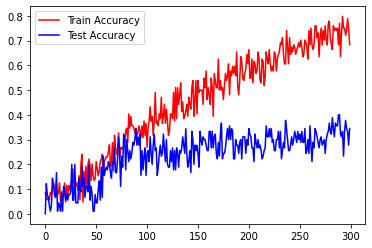

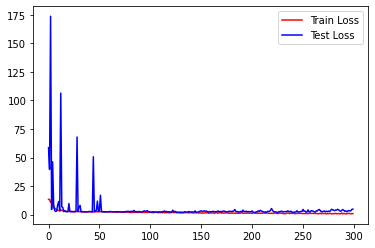

In [ ]:
plt.plot(history.history['accuracy'], 'r')
plt.plot(history.history['val_accuracy'], 'b')
plt.legend({'Train Accuracy': 'r', 'Test Accuracy':'b'})
plt.show()
plt.plot(history.history['loss'], 'r')
plt.plot(history.history['val_loss'], 'b')
plt.legend({'Train Loss': 'r', 'Test Loss':'b'})
plt.show()

In [ ]:
# model1.load_weights(train_path1+'/Results/model_complex.h5')
# y_pred_tr = model1.predict(X_train)
# y_tr2 = y_train.argmax(1)
# y_pred_tr = y_pred_tr.argmax(1)
# train_acc = accuracy_score(y_tr2, y_pred_tr)
# y_pred = model1.predict(X_test)
# y_te2 = y_test.argmax(1)
# y_pred = y_pred.argmax(1)
# test_acc = accuracy_score(y_te2, y_pred)
# print("Train Accuracy : ", train_acc)
# print("Test Accuracy : ", test_acc)